# Web scraping

In [ ]:
!pip install tf-playwright-stealth

In [ ]:
# EUvsDISINFO Scraper
# Import necessary libraries
import pandas as pd
import asyncio
import nest_asyncio
from playwright.async_api import async_playwright
from playwright_stealth import stealth_async        # Import stealth_async for stealth mode in order to avoid detection

nest_asyncio.apply()  # Apply nest_asyncio to allow nested event loops

async def scrape_eu_vs_disinfo():
    pw = None
    browser = None
    results = []  # Initialize an empty list to store results
    try:
        pw = await async_playwright().start()  # Start Playwright
        browser = await pw.chromium.launch(headless=False)  # Launch Chromium browser in non-headless mode because the website detects headless browsers
        page = await browser.new_page()  # Create a new page in the browser


        await stealth_async(page)  # Apply stealth mode to avoid detection
        url = f"https://euvsdisinfo.eu/disinformation-cases/page/1/?disinfo_countries%5B0%5D=country_77544&_=1750026467335"
        await page.goto(url, timeout=120000, wait_until='domcontentloaded')  # Navigate to the page
        await asyncio.sleep(1)  # Small delay for ethical scraping

        pagination_tags = await page.query_selector('div.b-pagination a:last-child')  # Select last pagination item
        num_pages = await pagination_tags.inner_text()  # Get the number of pages
        print(f"Number of pages: {num_pages}")
        num_pages = int(num_pages)

        for page_num in range(1, num_pages + 1):  # Iterating through web pages
            if page_num > 1:

                await stealth_async(page)  # Apply stealth mode to avoid detection
                print(f"Navigating to page {page_num}...")
                url = f"https://euvsdisinfo.eu/disinformation-cases/page/{page_num}/?disinfo_countries%5B0%5D=country_77544&_=1750026467335"
                await page.goto(url, timeout=120000, wait_until='domcontentloaded')  # Navigate to the page
                print(f"Page {page_num} loaded.")
                await asyncio.sleep(1)  # Small delay for ethical scraping

            article_cards = await page.query_selector_all('a.b-archive__database-item') # Select all article cards on the page

            # Extract data from the first few cards
            for i, card in enumerate(article_cards):
                outlet = []  # Initialize an empty list for outlets
                tags = []  # Initialize an empty list for tags
                title = "N/A"  # Initialize title as "N/A"
                summary = "N/A"  # Initialize summary as "N/A"
                response = "N/A"  # Initialize response as "N/A"
                date = "N/A"  # Initialize date as "N/A"
                languages = []  # Initialize an empty list for languages
                countries = []  # Initialize an empty list for countries

                url = await card.get_attribute('href') # Get the URL of the article

                article_page = await browser.new_page()  # Create a new page for article


                await stealth_async(article_page)  # Apply stealth mode to avoid detection
                await article_page.goto(f"https://euvsdisinfo.eu{url}", timeout=120000, wait_until='domcontentloaded')  # Navigate to the article page
                await asyncio.sleep(1) # Small delay for ethical scraping

                try:
                    await article_page.wait_for_selector('h1.b-page__title', timeout=100)  # Wait for the title to load
                except Exception as e:
                    title_tag = await article_page.query_selector('h1.b-report__title')  # Select the title of the article
                    title = await title_tag.inner_text() if title_tag else "N/A"  # Get the title text
                    title = title.replace("DISINFO: ", "")  # Clean the title text

                    summary_tag = await article_page.query_selector('div.b-report__summary')  # Select the summary of the article
                    summary = await summary_tag.inner_text() if summary_tag else "N/A"  # Get the summary text
                    summary = summary.replace("SUMMARY\n\n", "")  # Clean the summary text

                    response_tag = await article_page.query_selector('div.b-report__response')  # Select the response of the article
                    response = await response_tag.inner_text() if response_tag else "N/A"  # Get the response text
                    response = response.replace("RESPONSE\n\n", "")  # Clean the response text

                    details = await article_page.query_selector_all('ul.b-report__details-list li')  # Select the details of the article

                    if len(details) == 2:
                        date_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(1) span')  # Select the date of the article
                        date = await date_tag.inner_text() if date_tag else "N/A"  # Get the date text

                        countries_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(2) span')  # Select the countries of the article
                        countries = [await countries_tag.inner_text()]  # Get the countries text
                        countries = countries[0].split(", ") if countries else []  # Split the countries text into a list
                    elif len(details) >= 3:
                        outlet_tag = await article_page.query_selector_all('ul.b-report__details-list li:nth-child(1) a')  # Select the outlets of the article
                        for j, outlet_item in enumerate(outlet_tag):  # Iterate through each outlet
                            outlet_text = await outlet_item.inner_text()  # Get the outlet text
                            if outlet_text and not outlet_text.strip().__contains__("archived"):  # Clean the outlet text and append it to the outlet list
                                outlet.append(outlet_text.strip().replace("\\n(opens in a new tab)", "").replace("\n(opens in a new tab)", ""))

                        date_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(2) span')  # Select the date of the article
                        date = await date_tag.inner_text() if date_tag else "N/A"  # Get the date text

                        if len(details) == 4:
                            languages_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(3) span')  # Select the languages of the article
                            languages = [await languages_tag.inner_text()]  # Get the languages text
                            languages = languages[0].split(", ") if languages else []  # Split the languages text into a list
                            languages = list(set(languages))  # Remove duplicates

                            countries_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(4) span')  # Select the countries of the article
                            countries = [await countries_tag.inner_text()]  # Get the countries text
                            countries = countries[0].split(", ") if countries else []  # Split the countries text into a list
                        elif len(details) == 3:
                            languages = []

                            countries_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(3) span')  # Select the countries of the article
                            countries = [await countries_tag.inner_text()]  # Get the countries text
                            countries = countries[0].split(", ") if countries else []  # Split the countries text into a list

                    tags_tag = await article_page.query_selector_all('div.b-report__keywords a span')  # Select the tags of the article
                    for tag_item in tags_tag:  # Iterate through each tag
                        tag_text = await tag_item.inner_text()  # Get the tag text
                        if tag_text:
                            tags.append(tag_text.strip())  # Append the tag text to the tags list

                    results.append({  # Append the extracted data to the results list
                        'Title': title,
                        'URL': f"https://euvsdisinfo.eu{url}",
                        'Summary': summary,
                        'Response': response,
                        'Outlet': outlet,
                        'Date': date,
                        'Languages': languages,
                        'Countries': countries,
                        'Tags': tags
                    })
                await article_page.close()  # Close the article page after extracting data

        await browser.close()  # Close the browser after scraping
    except Exception as e:
        print(f"An error occurred during EUvsDISINFO search: {e}")
        # Optional: Take a screenshot on error for debugging
        # if page: await page.screenshot(path='error_screenshot.png')

    finally:
        if browser:  # Ensure the browser is closed
            await browser.close()
            print("Browser closed.")
        if pw:
            await pw.stop()  # Stop Playwright
            print("Playwright stopped.")

    return results  # Return the results list containing the scraped data

df = asyncio.run(scrape_eu_vs_disinfo())  # Run the scraping function
if df:
    df = pd.DataFrame(df)  # Convert the results list to a DataFrame
    print(f"Scraped {len(df)} results from EUvsDISINFO.")  # Display the number of results scraped
    df.to_csv('euvsdisinfo.csv', index=False)  # Save the DataFrame to a CSV file
else:
    print("\nNo results scraped from EUvsDISINFO.")  # Display a message if no results were scraped


# Web scraping (Export pages separately)

In [ ]:
# EUvsDISINFO Scraper
# Import necessary libraries
import pandas as pd
import asyncio
import nest_asyncio
from playwright.async_api import async_playwright
from playwright_stealth import stealth_async        # Import stealth_async for stealth mode in order to avoid detection

nest_asyncio.apply()  # Apply nest_asyncio to allow nested event loops

async def scrape_eu_vs_disinfo(page_num=1):
    pw = None
    browser = None
    results = []  # Initialize an empty list to store results
    try:
        pw = await async_playwright().start()  # Start Playwright
        browser = await pw.chromium.launch(headless=False)  # Launch Chromium browser in non-headless mode because the website detects headless browsers
        page = await browser.new_page()  # Create a new page in the browser


        await stealth_async(page)  # Apply stealth mode to avoid detection
        print(f"Navigating to page {page_num}...")
        url = f"https://euvsdisinfo.eu/disinformation-cases/page/{page_num}/?disinfo_countries%5B0%5D=country_77544&_=1750022717762"
        await page.goto(url, timeout=120000, wait_until='domcontentloaded')  # Navigate to the page
        print(f"Page {page_num} loaded.")
        await asyncio.sleep(1) # Small delay for ethical scraping

        article_cards = await page.query_selector_all('a.b-archive__database-item') # Select all article cards on the page
        # Extract data from the first few cards
        for i, card in enumerate(article_cards):
            outlet = []  # Initialize an empty list for outlets
            tags = []  # Initialize an empty list for tags
            title = "N/A"  # Initialize title variable
            summary = "N/A"  # Initialize summary variable
            response = "N/A"  # Initialize response variable
            date = "N/A"  # Initialize date variable
            languages = []  # Initialize an empty list for languages
            countries = []  # Initialize an empty list for countries

            url = await card.get_attribute('href') # Get the URL of the article

            article_page = await browser.new_page()  # Create a new page for article


            await stealth_async(article_page)  # Apply stealth mode to avoid detection
            await article_page.goto(f"https://euvsdisinfo.eu{url}", timeout=120000, wait_until='domcontentloaded')  # Navigate to the article page
            await asyncio.sleep(1) # Small delay for ethical scraping

            try:
                await article_page.wait_for_selector('h1.b-page__title', timeout=50)  # Wait for the title to load
            except Exception as e:
                title_tag = await article_page.query_selector('h1.b-report__title')  # Select the title of the article
                title = await title_tag.inner_text() if title_tag else "N/A"  # Get the title text
                title = title.replace("DISINFO: ", "")  # Clean the title text

                summary_tag = await article_page.query_selector('div.b-report__summary')  # Select the summary of the article
                summary = await summary_tag.inner_text() if summary_tag else "N/A"  # Get the summary text
                summary = summary.replace("SUMMARY\n\n", "")  # Clean the summary text

                response_tag = await article_page.query_selector('div.b-report__response')  # Select the response of the article
                response = await response_tag.inner_text() if response_tag else "N/A"  # Get the response text
                response = response.replace("RESPONSE\n\n", "")  # Clean the response text

                details = await article_page.query_selector_all('ul.b-report__details-list li')  # Select the details of the article

                if len(details) == 2:
                    date_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(1) span')  # Select the date of the article
                    date = await date_tag.inner_text() if date_tag else "N/A"  # Get the date text

                    countries_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(2) span')  # Select the countries of the article
                    countries = [await countries_tag.inner_text()]  # Get the countries text
                    countries = countries[0].split(", ") if countries else []  # Split the countries text into a list
                elif len(details) >= 3:
                    outlet_tag = await article_page.query_selector_all('ul.b-report__details-list li:nth-child(1) a')  # Select the outlets of the article
                    for j, outlet_item in enumerate(outlet_tag):  # Iterate through each outlet
                        outlet_text = await outlet_item.inner_text()  # Get the outlet text
                        if outlet_text and not outlet_text.strip().__contains__("archived"):  # Clean the outlet text and append it to the outlet list
                            outlet.append(outlet_text.strip().replace("\\n(opens in a new tab)", "").replace("\n(opens in a new tab)", ""))

                    date_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(2) span')  # Select the date of the article
                    date = await date_tag.inner_text() if date_tag else "N/A"  # Get the date text

                    if len(details) == 4:
                        languages_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(3) span')  # Select the languages of the article
                        languages = [await languages_tag.inner_text()]  # Get the languages text
                        languages = languages[0].split(", ") if languages else []  # Split the languages text into a list
                        languages = list(set(languages))  # Remove duplicates

                        countries_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(4) span')  # Select the countries of the article
                        countries = [await countries_tag.inner_text()]  # Get the countries text
                        countries = countries[0].split(", ") if countries else []  # Split the countries text into a list
                    elif len(details) == 3:
                        languages = []

                        countries_tag = await article_page.query_selector('ul.b-report__details-list li:nth-child(3) span')  # Select the countries of the article
                        countries = [await countries_tag.inner_text()]  # Get the countries text
                        countries = countries[0].split(", ") if countries else []  # Split the countries text into a list

                tags_tag = await article_page.query_selector_all('div.b-report__keywords a span')  # Select the tags of the article
                for tag_item in tags_tag:  # Iterate through each tag
                    tag_text = await tag_item.inner_text()  # Get the tag text
                    if tag_text:
                        tags.append(tag_text.strip())  # Append the tag text to the tags list

                results.append({  # Append the extracted data to the results list
                    'Title': title,
                    'URL': f"https://euvsdisinfo.eu{url}",
                    'Summary': summary,
                    'Response': response,
                    'Outlet': outlet,
                    'Date': date,
                    'Languages': languages,
                    'Countries': countries,
                    'Tags': tags
                })
            await article_page.close()  # Close the article page after extracting data

        await browser.close()  # Close the browser after scraping
    except Exception as e:
        print(f"An error occurred during EUvsDISINFO search: {e}")
        # Optional: Take a screenshot on error for debugging
        # if page: await page.screenshot(path='error_screenshot.png')

    finally:
        if browser:  # Ensure the browser is closed
            await browser.close()
            print("Browser closed.")
        if pw:
            await pw.stop()  # Stop Playwright
            print("Playwright stopped.")

    return results  # Return the results list containing the scraped data

pages = [5, 6, 7, 10, 11, 17, 24, 25, 27, 57, 60, 65, 70, 78, 97, 211, 488]  # Pages which we had to rescrape

for i in pages:
    df = asyncio.run(scrape_eu_vs_disinfo(i))  # Run the scraping function for each page
    if df:
        df = pd.DataFrame(df)  # Convert the results list to a DataFrame
        df.to_csv(f'euvsdisinfo_results_page_{i}.csv', index=False)  # Save the DataFrame to a CSV file
    else:
        print(f"\nNo results scraped from EUvsDISINFO for page {i}.")  # Display a message if no results were scraped


In [ ]:
import pandas as pd

df = pd.DataFrame([])  # Initialize an empty DataFrame to store all pages
for i in range(1, 515):
    pg = pd.read_csv(f'euvsdisinfo_results_page_{i}.csv')  # Read the CSV file for each page
    df = pd.concat([df, pg], ignore_index=True)  # Append the DataFrame for each page to the list

df.to_csv('euvsdisinfo_results.csv', index=False)  # Save the combined DataFrame to a CSV file

# Sentiment Analysis

In [43]:
!pip install torch transformers
!pip install tf-keras


/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.0/821.0 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 29.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 39.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 21.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 25.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 26.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216

In [1]:
from transformers import pipeline
import pandas as pd

# Initialize the emotion classification pipeline
emotion_pipe = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base", top_k=1)

/home/psimandan/PyCharmMiscProject/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-18 03:29:45.361130: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750206585.380508  173969 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750206585.385390  173969 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750206585.399059  173969 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target mor

In [2]:
df = pd.read_csv('euvsdisinfo_results.csv')

df.columns

Index(['Title', 'URL', 'Summary', 'Response', 'Outlet', 'Date', 'Languages',
       'Countries', 'Tags'],
      dtype='object')

In [ ]:
!pip install textblob
import pandas as pd
from textblob import TextBlob

# Function to calculate sentiment polarity
def get_sentiment(text):
    if pd.isna(text):
        return 0.0
    return TextBlob(str(text)).sentiment.polarity

# Apply sentiment analysis to the 'Summary' column
df['Sentiment_Summary'] = df['Summary'].apply(get_sentiment)
df['Sentiment_Summary_Label'] = df['Sentiment_Summary'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))

df['Emotion_Summary_Label'] = df['Summary'].apply(lambda x: emotion_pipe(x)[0][0]['label'])


# Save the DataFrame with sentiment analysis results to a new CSV file
df.to_csv('euvsdisinfo_results_with_sentiment.csv', index=False)

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


# Read CSV and preprocessing

In [1]:
# Install required visualization and analysis libraries if not already installed
!pip install wordcloud matplotlib seaborn
!pip install networkx scikit-learn


  Using cached wordcloud-1.9.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached matplotlib-3.10.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached numpy-2.3.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached pillow-11.2.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (8.9 kB)
  Using cached contourpy-1.3.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.4-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (106 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached pandas-2.3.0-cp312-cp312-manylinux_2_17_x

In [ ]:
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Load your dataset from CSV file
df = pd.read_csv('euvsdisinfo_results_with_sentiment.csv')

# Convert the 'date' column to pandas datetime objects for further analysis
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.to_period('M')

# Convert string representations of lists back to actual lists
df['Tags'] = df["Tags"].apply(ast.literal_eval)
df['Outlet'] = df['Outlet'].apply(ast.literal_eval)
df['Countries'] = df['Countries'].apply(ast.literal_eval)


/tmp/ipykernel_712406/2826088340.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


# Emotion Analysis for each year

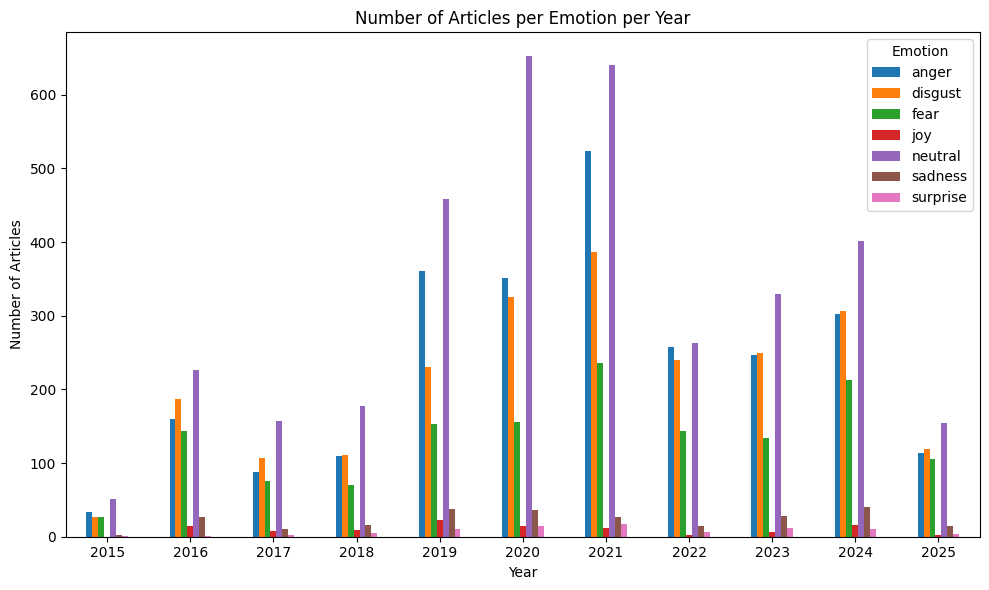

In [2]:
emotion_counts = df.groupby(['Year', 'Emotion_Summary_Label']).size().reset_index(name='count')

# Pivot for plotting
pivot = emotion_counts.pivot(index='Year', columns='Emotion_Summary_Label', values='count').fillna(0)

# Plot
pivot.plot(kind='bar', figsize=(10, 6))
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Emotion per Year')
plt.xticks(rotation=0)
plt.legend(title='Emotion')
plt.tight_layout()
plt.show()

In [3]:
!pip install plotly

In [4]:
!pip install nbformat

In [5]:
import plotly.express as px

fig = px.bar(emotion_counts, x='Year', y='count', color='Emotion_Summary_Label',
             title='Number of Articles per Emotion per Year',
             labels={'Year': 'Year', 'count': 'Count', 'Emotion_Summary_Label': 'Emotion'})
fig.update_layout(barmode='group')
fig.show()

# Number of articles per year

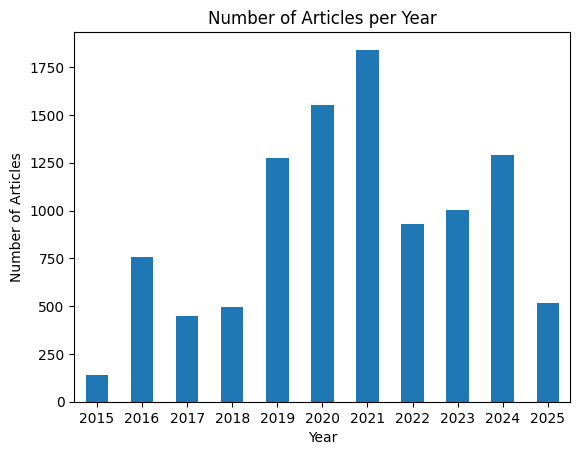

In [105]:
# === Plot 1: Number of articles per year ===
plt.figure()
df['Year'].value_counts().sort_index().plot(kind='bar')
plt.title('Number of Articles per Year')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.show()



# Number of articles per month

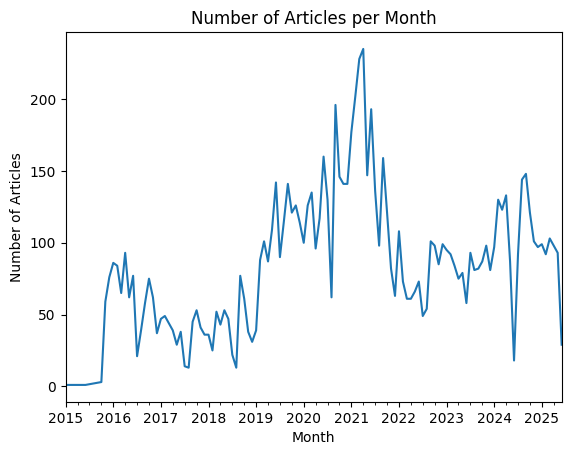

In [12]:
# === Plot 2: Number of articles per month ===
plt.figure()
df['Month'].value_counts().sort_index().plot(kind='line')
plt.title('Number of Articles per Month')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.show()


# Wordcloud

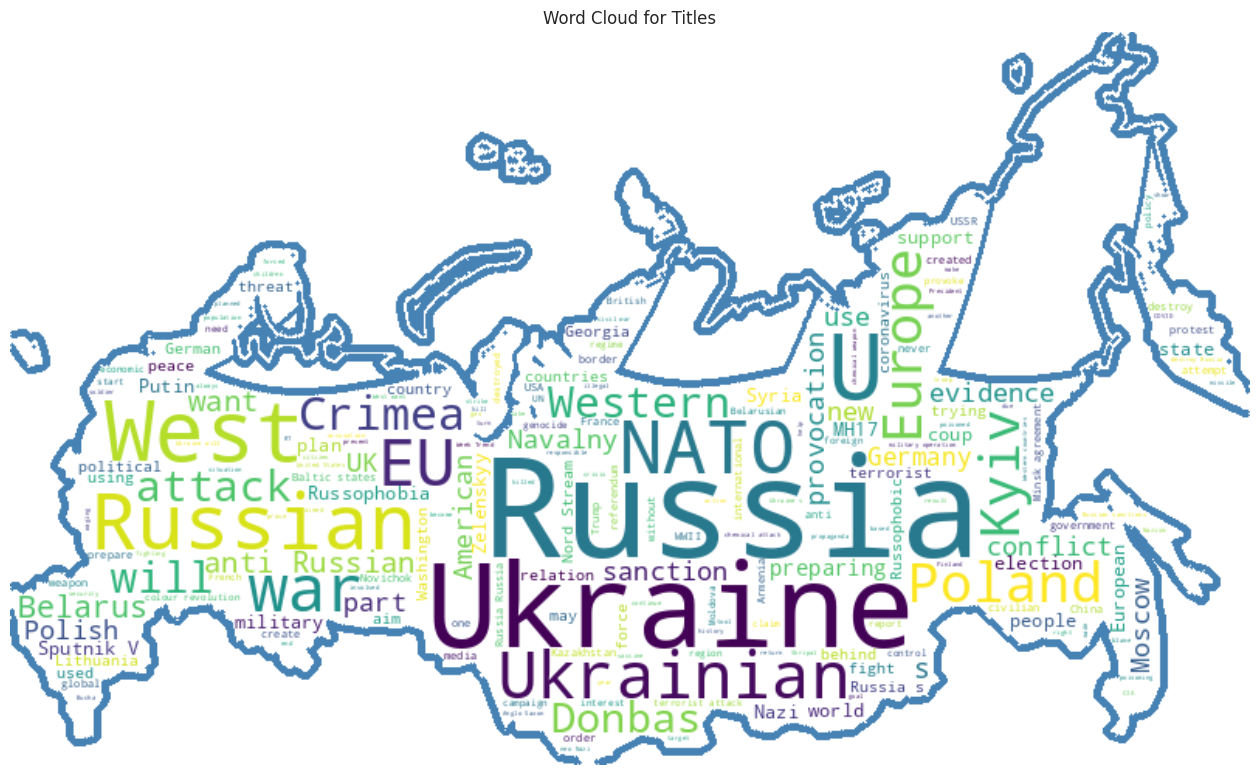

In [23]:
# === Plot 3: Word Cloud for Titles ===
import numpy as np
from PIL import Image

mask = np.array(Image.open("russia2.png"))

title_text = ' '.join(df['Title'].dropna().astype(str).tolist())
wordcloud = WordCloud(mask=mask, width=800, height=473, background_color='white', contour_width=3, contour_color='steelblue').generate(title_text)
plt.figure(figsize=(16, 16), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Titles')
plt.show()



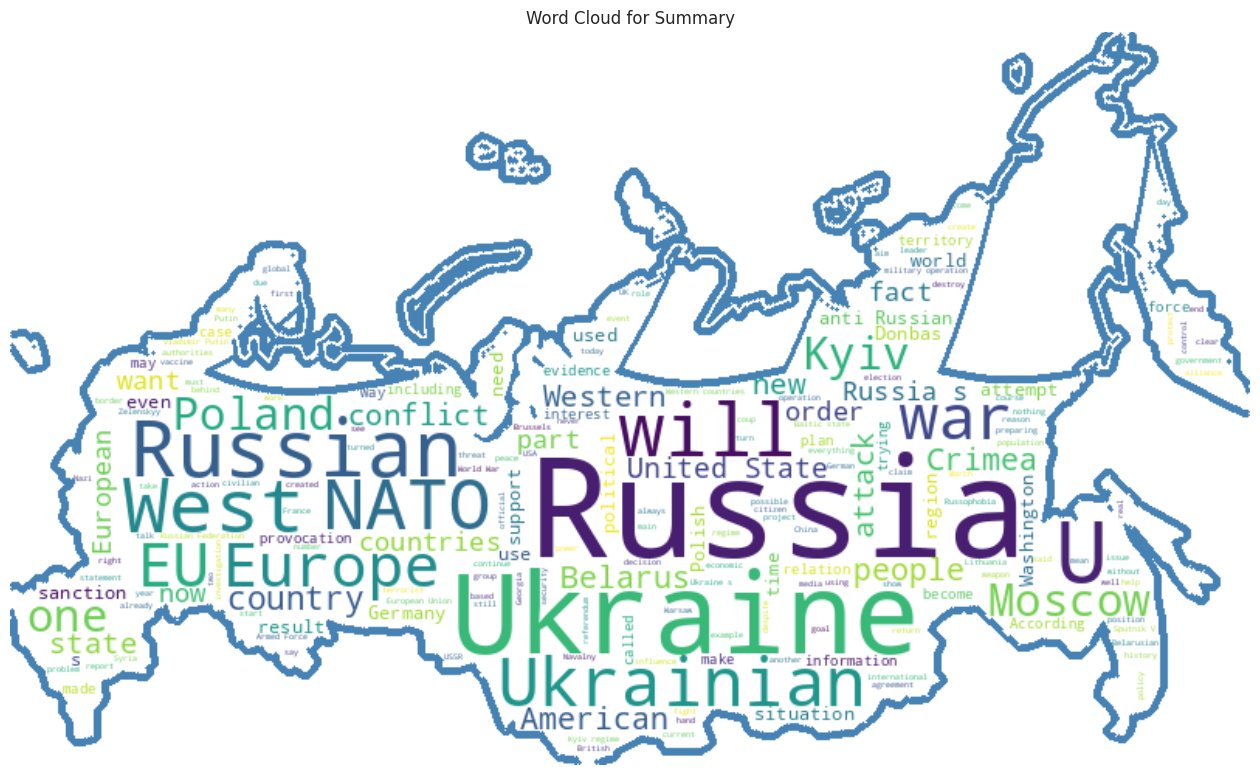

In [25]:
# === Plot 4: Word Cloud for Summaries ===
desc_text = ' '.join(df['Summary'].dropna().astype(str).tolist())
wordcloud = WordCloud(mask=mask, width=800, height=473, background_color='white', contour_width=3, contour_color='steelblue').generate(desc_text)
plt.figure(figsize=(16, 16), facecolor=None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Summary')
plt.show()


# Top 10 countries by occurrence

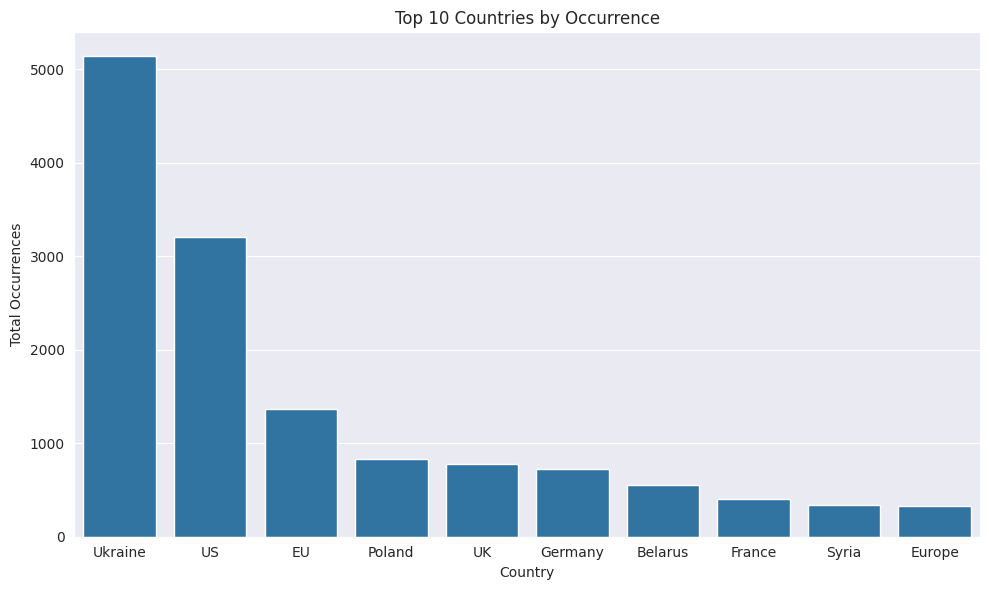

In [ ]:
# === Plot 5: Top 10 countries by occurrence ===
country_lists = df['Countries']
all_countries = [country for countries in country_lists for country in countries]
country_counts = Counter(all_countries)
country_counts_df = pd.DataFrame(country_counts.items(), columns=['Country', 'Count']).sort_values('Count', ascending=False)
country_counts_df=country_counts_df.iloc[1:]

plt.figure(figsize=(10, 6))
sns.barplot(data=country_counts_df.head(10), x='Country', y='Count')
plt.title('Top 10 Countries by Occurrence')
plt.xlabel('Country')
plt.ylabel('Total Occurrences')
plt.tight_layout()
plt.show()

# Top 10 outlets by number of articles

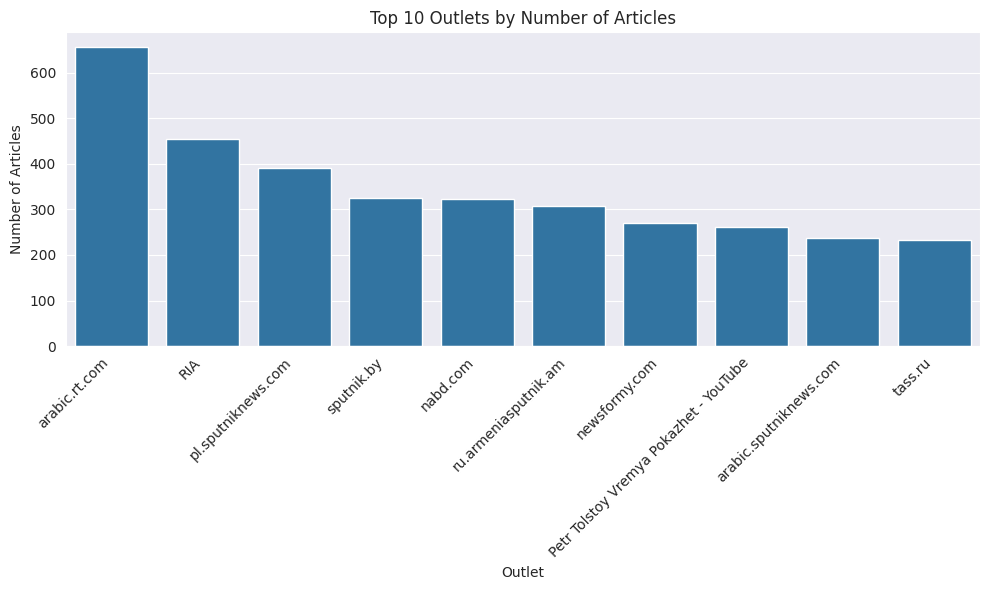

In [ ]:
# === Plot 6: Top 10 outlets by number of articles ===
outlet_lists = df['Outlet']
all_outlets = [outlet for outlets in outlet_lists for outlet in outlets]
outlet_counts = Counter(all_outlets)
outlet_counts_df = pd.DataFrame(outlet_counts.items(), columns=['Outlet', 'Count']).sort_values('Count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=outlet_counts_df.head(10), x='Outlet', y='Count')
plt.title('Top 10 Outlets by Number of Articles')
plt.xlabel('Outlet')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



# Top 10 tags by total occurrence

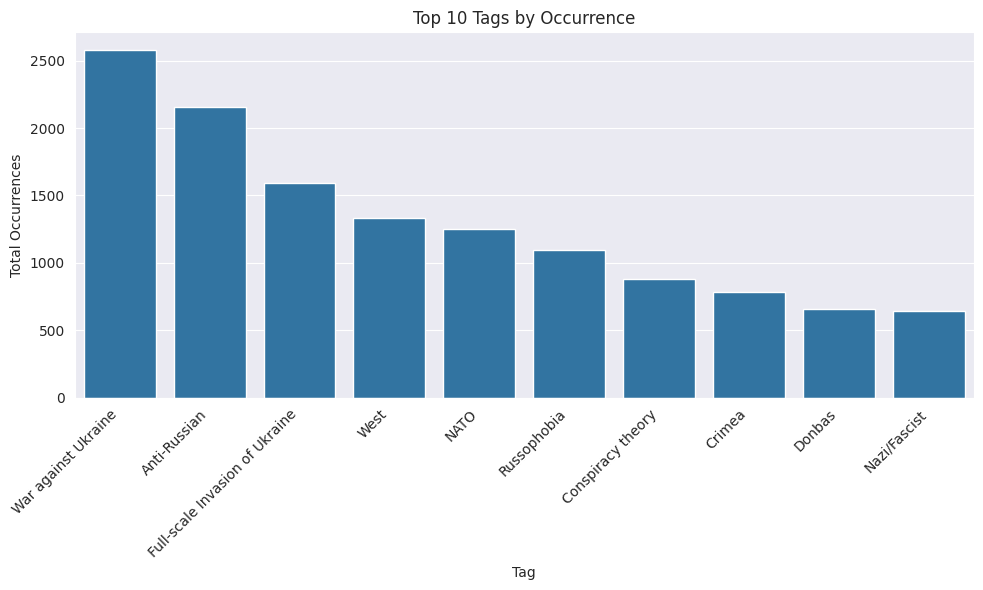

In [115]:
# === Plot 7: Top 10 tags by total occurrence ===
tag_lists = df["Tags"]
all_tags = [tag for tags in tag_lists for tag in tags]
tag_counts = Counter(all_tags)
tag_counts_df = pd.DataFrame(tag_counts.items(), columns=['Tag', 'Count']).sort_values('Count', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=tag_counts_df.head(10), x='Tag', y='Count')
plt.title('Top 10 Tags by Occurrence')
plt.xlabel('Tag')
plt.ylabel('Total Occurrences')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



# Top 3 Tags for each year

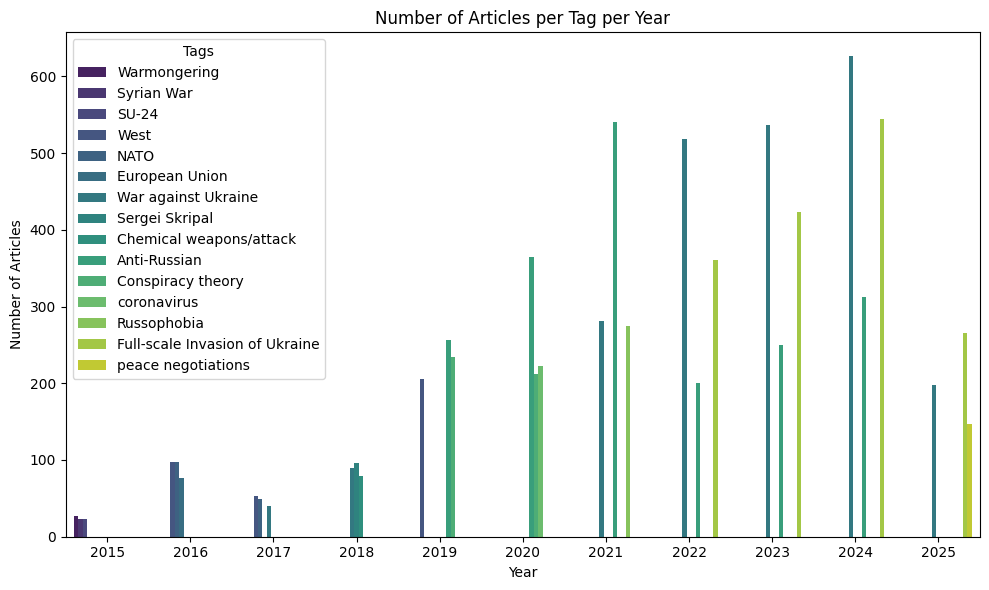

In [ ]:
# === Plot 8: Number of articles per tag per year ===
# First, we need to explode the 'Tags' column to have one tag per row for each article 
new_df = df[['Year', 'Tags']]
new_df = new_df.explode('Tags')

# Now we can count the occurrences of each tag per year
tag_counts = new_df.groupby(['Year', 'Tags']).size().reset_index(name='count').sort_values(by='count', ascending=False)
tag_counts = tag_counts.groupby(['Year']).head(3)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Year', y='count', hue='Tags', data=tag_counts, palette='viridis')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Tag per Year')
plt.xticks(rotation=0)
plt.legend(title='Tags')
plt.tight_layout()
plt.show()


In [ ]:
import plotly.express as px

# Plot using Plotly
fig = px.bar(tag_counts, x='Year', y='count', color='Tags',
             title='Number of Articles per Tag per Year',
             labels={'Year': 'Year', 'count': 'Count', 'Tags': 'Tags'})
fig.update_layout(barmode='group')
fig.show()

# PoS & NER Tagging

In [7]:
# @title Import spacy and its NER model { display-mode: "form" }
# Remove comment below if spacy is not installed
!pip install --quiet spacy

# Spacy has 3 CPU-optimized en_core_web models: sm (small - 12MB), md (medium - 40MB), lg (large - 560MB)
!python -m spacy download en_core_web_lg --quiet # Install the smallest en_core_web NER model
# Can replace with any of the larger ones if not bottlenecked by network/cpu

import spacy

# Load the pre-trained model
nlp = spacy.load('en_core_web_lg') # Use en_core_web_sm if en_core_web_lg takes too long to download and load, but it will be at the cost of entity recognition accuracy

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [ ]:
import string

ner_df = pd.DataFrame()

# Iterate through each text and year in the DataFrame
for text, year in zip(df['Summary'], df['Year']):
    # Clean the text to remove unwanted characters
    allowed_chars = string.ascii_letters + string.digits + string.whitespace
    text = ''.join(c for c in text if c in allowed_chars)

    # Tokenize the text
    doc = nlp(text)

    # Perform PoS and NER tagging
    pos_ner_tags = [(token.text, token.pos_, token.ent_type_) for token in doc]

    text_df = pd.DataFrame(pos_ner_tags, columns=['Word', 'PoS', 'NER'])
    text_df = text_df.assign(Year=year)

    ner_df = pd.concat([ner_df, text_df], ignore_index=True)

ner_df

,Word,PoS,NER,Year
0,Russia,PROPN,GPE,2025
1,proved,VERB,,2025
2,the,DET,,2025
3,great,ADJ,,2025
4,strength,NOUN,,2025
...,...,...,...,...
647405,forbidden,VERB,,2015
647406,to,PART,,2015
647407,do,VERB,,2015
647408,the,DET,,2015


In [82]:
!pip install nltk

  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached regex-2024.11.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached regex-2024.11.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (796 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nltk]1/2 [nltk]


# Top 5 PoS(NOUN, VERB, ADJ, ADV) per Year

In [ ]:
from plotly.subplots import make_subplots

# Nouns
nouns = ner_df[ner_df['PoS'] == 'NOUN']
noun_counts = nouns.groupby(['Word', 'Year']).size().sort_values(ascending=False).reset_index(name='count')
noun_counts = noun_counts.sort_values(by=['Year', 'count'], ascending=[True, False])
noun_counts = noun_counts.groupby(['Year']).head(5)  # Get top 10 nouns for each year
noun_counts['Word_Year'] = noun_counts['Word'] + ' (' + noun_counts['Year'].astype(str) + ')'

# Verbs
verbs = ner_df[ner_df['PoS'] == 'VERB']
verb_counts = verbs.groupby(['Word', 'Year']).size().sort_values(ascending=False).reset_index(name='count')
verb_counts = verb_counts.sort_values(by=['Year', 'count'], ascending=[True, False])
verb_counts = verb_counts.groupby(['Year']).head(5)
verb_counts['Word_Year'] = verb_counts['Word'] + ' (' + verb_counts['Year'].astype(str) + ')'

# Adjectives
adjs = ner_df[ner_df['PoS'] == 'ADJ']
adj_counts = adjs.groupby(['Word', 'Year']).size().sort_values(ascending=False).reset_index(name='count')
adj_counts = adj_counts.sort_values(by=['Year', 'count'], ascending=[True, False])
adj_counts = adj_counts.groupby(['Year']).head(5)
adj_counts['Word_Year'] = adj_counts['Word'] + ' (' + adj_counts['Year'].astype(str) + ')'

# Adverbs
advs = ner_df[ner_df['PoS'] == 'ADV']
adv_counts = advs.groupby(['Word', 'Year']).size().sort_values(ascending=False).reset_index(name='count')
adv_counts = adv_counts.sort_values(by=['Year', 'count'], ascending=[True, False])
adv_counts = adv_counts.groupby(['Year']).head(5)
adv_counts['Word_Year'] = adv_counts['Word'] + ' (' + adv_counts['Year'].astype(str) + ')'

# Create subplots for top 5 nouns, verbs, adjectives, and adverbs per year
fig = make_subplots(rows=4, cols=1,
                    vertical_spacing=0.1,
                    subplot_titles=('Top 5 Nouns per Year', 'Top 5 Verbs per Year', 'Top 5 Adjectives per Year', 'Top 5 Adverbs per Year'))

fig.add_trace(
    px.bar(noun_counts, x='Word_Year', y='count', color='Year',
           title='Top 5 Nouns per Year',
           labels={'Year': 'Year', 'count': 'Count', 'Word_Year': 'Noun'}).data[0],
    row=1, col=1
)
fig.add_trace(
    px.bar(verb_counts, x='Word_Year', y='count', color='Year', 
           title='Top 5 Verbs per Year',
           labels={'Year': 'Year', 'count': 'Count', 'Word_Year': 'Verb'}).data[0],
    row=2, col=1
)
fig.add_trace(
    px.bar(adj_counts, x='Word_Year', y='count', color='Year', 
           title='Top 5 Adjectives per Year',
           labels={'Year': 'Year', 'count': 'Count', 'Word_Year': 'Adjective'}).data[0],
    row=3, col=1
)
fig.add_trace(
    px.bar(adv_counts, x='Word_Year', y='count', color='Year', 
           title='Top 5 Adverbs per Year',
           labels={'Year': 'Year', 'count': 'Count', 'Word_Year': 'Adverb'}).data[0],
    row=4, col=1
)

# Update layout for better readability
fig.update_layout(barmode='group', xaxis1_tickangle=-45, height=2000, xaxis2_tickangle=-45,
    xaxis3_tickangle=-45,
    xaxis4_tickangle=-45)
fig.show()

# Top 5 NER(GPE, NORP, ORG, PERSON) per Year

In [ ]:
# Geopolitical Entities (GPE)
gpe = ner_df[ner_df['NER'] == 'GPE']
gpe_counts = gpe.groupby(['Word', 'Year']).size().sort_values(ascending=False).reset_index(name='count')
gpe_counts = gpe_counts.sort_values(by=['Year', 'count'], ascending=[True, False])
gpe_counts = gpe_counts.groupby(['Year']).head(5)  # Get top 10 GPEs for each year
gpe_counts['Word_Year'] = gpe_counts['Word'] + ' (' + gpe_counts['Year'].astype(str) + ')'

# Non-Person Entities (NORP)
norp = ner_df[ner_df['NER'] == 'NORP']
norp_counts = norp.groupby(['Word', 'Year']).size().sort_values(ascending=False).reset_index(name='count')
norp_counts = norp_counts.sort_values(by=['Year', 'count'], ascending=[True, False])
norp_counts = norp_counts.groupby(['Year']).head(5)  # Get top 10 NORPs for each year
norp_counts['Word_Year'] = norp_counts['Word'] + ' (' + norp_counts['Year'].astype(str) + ')'

# Organizations (ORG)
org = ner_df[ner_df['NER'] == 'ORG']
org_counts = org.groupby(['Word', 'Year']).size().sort_values(ascending=False).reset_index(name='count')
org_counts = org_counts.sort_values(by=['Year', 'count'], ascending=[True, False])
org_counts = org_counts.groupby(['Year']).head(5)  # Get top 10 ORGs for each year
org_counts['Word_Year'] = org_counts['Word'] + ' (' + org_counts['Year'].astype(str) + ')'

# People (PERSON)
person = ner_df[ner_df['NER'] == 'PERSON']
person_counts = person.groupby(['Word', 'Year']).size().sort_values(ascending=False).reset_index(name='count')
person_counts = person_counts.sort_values(by=['Year', 'count'], ascending=[True, False])
person_counts = person_counts.groupby(['Year']).head(5)  # Get top 10 PERSONs for each year
person_counts['Word_Year'] = person_counts['Word'] + ' (' + person_counts['Year'].astype(str) + ')'


# Create subplots for top 5 GPE, NORP, ORG, and PERSON per year
fig = make_subplots(rows=4, cols=1,
                    vertical_spacing=0.1,
                    subplot_titles=('Top 5 GPE per Year', 'Top 5 NORP per Year', 'Top 5 ORG per Year', 'Top 5 PERSON per Year'))

fig.add_trace(
    px.bar(gpe_counts, x='Word_Year', y='count', color='Year',
             title='Top 5 GPE per Year',
             labels={'Year': 'Year', 'count': 'Count', 'Word_Year': 'GPE'}).data[0],
    row=1, col=1
)
fig.add_trace(
    px.bar(norp_counts, x='Word_Year', y='count', color='Year',
             title='Top 5 NORP per Year',
             labels={'Year': 'Year', 'count': 'Count', 'Word_Year': 'NORP'}).data[0],
    row=2, col=1
)
fig.add_trace(
    px.bar(org_counts, x='Word_Year', y='count', color='Year',
             title='Top 5 ORG per Year',
             labels={'Year': 'Year', 'count': 'Count', 'Word_Year': 'ORG'}).data[0],
    row=3, col=1
)
fig.add_trace(
    px.bar(person_counts, x='Word_Year', y='count', color='Year',
             title='Top 5 PERSON per Year',
             labels={'Year': 'Year', 'count': 'Count', 'Word_Year': 'PERSON'}).data[0],
    row=4, col=1
)

# Update layout for better readability
fig.update_layout(barmode='group', xaxis1_tickangle=-45, height=2000, xaxis2_tickangle=-45,
    xaxis3_tickangle=-45,
    xaxis4_tickangle=-45)
fig.show()

# Topic Analysis

In [108]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re
import string

# Ensure necessary NLTK data is downloaded
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/wordnet')
    nltk.data.find('taggers/averaged_perceptron_tagger')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('punkt_tab')
    nltk.data.find('averaged_perceptron_tagger_eng')
except LookupError:
    print("Downloading necessary NLTK data...")
    nltk.download('punkt', quiet=True)
    nltk.download('punkt_tab')
    nltk.download('wordnet', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('averaged_perceptron_tagger_eng')


lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add some common wiki markup/noise to stopwords
# stop_words.update(['ref', 'cite', 'name', 'http', 'https', 'www', 'com', 'org', 'html', 'also', 'may', 'use', 'first', 'one', 'see', 'page', 'article'])

# Helper function to get WordNet POS tag (from Cell 26)
def nltk_pos_to_wordnet_pos(nltk_tag):
    if nltk_tag.startswith('J'): return wordnet.ADJ
    elif nltk_tag.startswith('V'): return wordnet.VERB
    elif nltk_tag.startswith('N'): return wordnet.NOUN
    elif nltk_tag.startswith('R'): return wordnet.ADV
    else: return None

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # 3. Remove wiki markup like [[File:...]], {{...}}, ==...== etc.
    text = re.sub(r'\[\[(?:[^\]|]*\|)?([^\]|]*)\]\]', r'\1', text) # Keep link text [[Category:Foo|Bar]] -> Bar
    text = re.sub(r'\{\{[^}]*\}\}', '', text) # Remove templates {{...}}
    text = re.sub(r'==\s*[^=]*\s*==', '', text) # Remove section headings == ... ==
    text = re.sub(r"\'\'\'?|\'\'", '', text) # Remove bold/italic ''', ''
    # 4. Remove punctuation and numbers
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))
    # 5. Tokenize
    tokens = word_tokenize(text)
    # 6. Get POS tags
    pos_tags = nltk.pos_tag(tokens)
    # 7. Lemmatize and remove stopwords/short words
    lemmatized_tokens = [
        lemmatizer.lemmatize(word, pos=nltk_pos_to_wordnet_pos(tag) or wordnet.NOUN) # Default to noun if POS unknown
        for word, tag in pos_tags
        if word.isalpha() and len(word) > 2 and word not in stop_words
    ]
    return ' '.join(lemmatized_tokens)

topic_df = df.copy()
print("Preprocessing documents...")
topic_df['Summary'] = topic_df['Summary'].apply(preprocess_text)
print("Preprocessing complete.")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/psimandan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/psimandan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Preprocessing documents...
Preprocessing complete.


In [110]:
# --- Displaying Topics ---
def print_top_words(model, feature_names, n_top_words):
    print(f"\n--- Top {n_top_words} words per topic ---")
    for topic_idx, topic in enumerate(model.components_):
        # model.components_ stores word distributions for each topic
        # argsort() gives the indices that would sort the array
        # [:-n_top_words - 1:-1] gets the indices of the top N words in descending order
        top_words_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_indices]
        print(f"Topic #{topic_idx}: {' | '.join(top_words)}")

In [146]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
documents = topic_df['Summary'].values
document_names = topic_df['Title'].values

n_topics = 10

def run_lda(n_topics, documents):
    print(f"\n--- Running LDA with {n_topics} topics ---")
    vectorizer = CountVectorizer(min_df=5, max_df=0.9, ngram_range=(1,2))
    dtm = vectorizer.fit_transform(documents)

    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda_model.fit(dtm)

    feature_names = vectorizer.get_feature_names_out()
    print_top_words(lda_model, feature_names, 10)

run_lda(n_topics, documents)


--- Running LDA with 10 topics ---

--- Top 10 words per topic ---
Topic #0: russian | navalny | medium | election | russia | case | information | western | service | one
Topic #1: russia | crimea | russian | sanction | ukraine | referendum | part | moscow | west | vote
Topic #2: poland | russia | belarus | polish | ukraine | country | agreement | europe | war | european
Topic #3: russia | state | united | united state | world | country | weapon | biological | chemical | international
Topic #4: russia | europe | european | vaccine | russian | country | sputnik | coronavirus | gas | world
Topic #5: ukraine | russia | russian | people | ukrainian | west | state | war | kyiv | country
Topic #6: ukraine | russia | nuclear | weapon | military | ukrainian | use | west | war | power
Topic #7: russia | nato | military | war | ukraine | country | west | state | conflict | russian
Topic #8: russian | ukrainian | force | attack | military | civilian | kyiv | missile | provocation | army
Topic #9

In [148]:
!pip install pyldavis --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [149]:
import pyLDAvis
import pyLDAvis.lda_model
import warnings
import pandas as pd # Import pandas to check version if needed

vectorizer = CountVectorizer(min_df=5, max_df=0.9, ngram_range=(1,2))  # Adjust parameters as needed
dtm = vectorizer.fit_transform(documents)

lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_model.fit(dtm)

# Check pandas version being used
try:
    print(f"Using pandas version: {pd.__version__}")
except Exception as e:
    print(f"Could not check pandas version: {e}")

# Enable notebook mode for pyLDAvis
pyLDAvis.enable_notebook()

print("Preparing LDA visualization data...")

# --- Check Inputs ---
if 'vectorizer' not in locals() or 'lda_model' not in locals() or 'dtm' not in locals():
    print("ERROR: Missing required objects (vectorizer, lda_model, or dtm).")
    print("Please ensure cells [29] and [31] were run successfully after restarting the runtime.")
else:
    # --- Compatibility Patch for pyLDAvis and newer scikit-learn ---
    patch_applied = False
    vectorizer_usable = False
    try:
        if hasattr(vectorizer, 'get_feature_names_out') and not hasattr(vectorizer, 'get_feature_names'):
            # Has new method, lacks old: Apply patch
            feature_names_for_patch = vectorizer.get_feature_names_out()
            def get_feature_names_compat():
                return feature_names_for_patch
            vectorizer.get_feature_names = get_feature_names_compat
            patch_applied = True
            vectorizer_usable = True
            print("Applied compatibility patch for vectorizer.get_feature_names().")
        elif hasattr(vectorizer, 'get_feature_names'):
            # Already has the old method (less likely in new sklearn, but possible)
            print("Vectorizer already has get_feature_names(). Patch not needed.")
            patch_applied = True # Patch technically not applied, but method exists
            vectorizer_usable = True
        else:
            # Lacks both methods - something is wrong with the vectorizer
             print("ERROR: CountVectorizer object lacks expected feature name methods.")

    except Exception as patch_error:
        print(f"Error during compatibility patch setup: {patch_error}")


    # --- Create Visualization Data ---
    if vectorizer_usable:
        try:
            print("Attempting pyLDAvis.lda_model.prepare()...")
            # Suppress warnings during prepare
            with warnings.catch_warnings():
                 warnings.simplefilter("ignore") # Ignore all warnings for cleaner output here
                 # The line below was modified to disable parallel processing by setting `n_jobs=1`.
                 vis_data = pyLDAvis.lda_model.prepare(lda_model, dtm, vectorizer, mds='mmds', n_jobs=1) # Changed mds to 'mmds' - sometimes more stable

            print("Visualization data prepared successfully.")

            # Display the visualization
            print("\n--- pyLDAvis Interactive Visualization ---")
            display(vis_data)

        except Exception as e:
             # Print any error that occurs *during* prepare
             print(f"\n--- ERROR during pyLDAvis.lda_model.prepare ---")
             print(f"Error Type: {type(e).__name__}")
             print(f"Error Details: {e}")
             print("------------------------------------------------")
             print("This might indicate remaining library incompatibilities.")
             print("Ensure scikit-learn, pandas, and pyLDAvis versions work together.")
    else:
        print("Skipping pyLDAvis visualization because the vectorizer object could not be prepared.")

Using pandas version: 2.3.0
Preparing LDA visualization data...
Applied compatibility patch for vectorizer.get_feature_names().
Attempting pyLDAvis.lda_model.prepare()...
Visualization data prepared successfully.

--- pyLDAvis Interactive Visualization ---


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.189391 -0.137974       1        1  12.585716
7     -0.228455  0.030637       2        1  12.574222
5     -0.070110 -0.064070       3        1  12.267173
0      0.244737 -0.038059       4        1  12.065424
1      0.155126 -0.195311       5        1  10.737296
8      0.229101  0.206040       6        1   9.632570
4      0.059790  0.057184       7        1   9.022570
6     -0.173747  0.153365       8        1   7.785187
3     -0.017679  0.226664       9        1   7.080345
9     -0.009371 -0.238476      10        1   6.249498, topic_info=            Term         Freq        Total Category  logprob  loglift
6214        nato  1946.000000  1946.000000  Default  30.0000  30.0000
10649    ukraine  5031.000000  5031.000000  Default  29.0000  29.0000
10873  ukrainian  2989.000000  2989.000000  Default  28.0000  28.0000
7229      poland  1080.000000  1080.000000  Default  27.0000  27.0000
2251      crimea   993.000000   993.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
9121         say    88.425964   699.117568  Topic10  -5.6728   0.7050
11147        use    94.857535  1382.139756  Topic10  -5.6026   0.0937
10048    support    85.009054   698.390489  Topic10  -5.7122   0.6666
7033      people    88.059448  1356.394511  Topic10  -5.6770   0.0381
11406        war    90.016506  2155.429201  Topic10  -5.6550  -0.4031

[745 rows x 6 columns], token_table=       Topic      Freq              Term
term                                    
3          2  0.035763          abkhazia
3          9  0.929839          abkhazia
60         4  0.295611        accusation
60         5  0.625144        accusation
60         6  0.043615        accusation
...      ...       ...               ...
11949      2  0.010411         zelenskyy
11949      3  0.049451         zelenskyy
11949      8  0.039040         zelenskyy
11949     10  0.884908         zelenskyy
11952     10  0.927497  zelenskyy regime

[2102 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 6, 1, 2, 9, 5, 7, 4, 10])

# Information Retrieval

In [106]:
!pip install sentence-transformers
!pip install hf_xet

  Using cached sentence_transformers-4.1.0-py3-none-any.whl.metadata (13 kB)
  Using cached transformers-4.52.4-py3-none-any.whl.metadata (38 kB)
  Using cached torch-2.7.1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (29 kB)
  Using cached huggingface_hub-0.33.0-py3-none-any.whl.metadata (14 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached PyYAML-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
  Using cached hf_xet-1.1.4-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (879 bytes)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.6.77-py3-none-manylinux2014_x86_64.whl.

In [143]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd

# Load your data
df = pd.read_csv('euvsdisinfo_results_with_sentiment.csv')
texts = df['Summary'].dropna().tolist()  # Use the 'Summary' column (or another text column if needed)

from sklearn.feature_extraction.text import TfidfVectorizer

# Setup the vectorizer with necessary preprocessing settings
vectorizer = TfidfVectorizer(
    lowercase=True,        # Convert all characters to lowercase before tokenizing
    stop_words='english',  # Remove stopwords
    max_df=0.95,           # Terms that appear in more than 95% of the documents are ignored
    min_df=2,              # Terms that appear in less than 2 documents are ignored
    max_features=10000     # Only consider the top 10,000 features ordered by term frequency across the corpus
)

# Apply vectorization to the text data
tfidf_matrix = vectorizer.fit_transform(texts)


from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Function to perform the query and retrieve documents
def retrieve_documents(query, vectorizer, tfidf_matrix, top_k=5):
    # Transform the query to the same vector space as the documents
    query_vec = vectorizer.transform([query])

    # Compute the cosine similarity between query vector and all document vectors
    similarities = cosine_similarity(query_vec, tfidf_matrix).flatten()

    # Get the top k documents with the highest similarity scores
    top_indices = np.argsort(-similarities)[:top_k]  # argsort returns indices of sorted array

    return top_indices, similarities[top_indices]

# Example query 1
query = "Crimea annexation was welcomed by the Crimean people"
top_indices, scores = retrieve_documents(query, vectorizer, tfidf_matrix)

# Print the results
print("Top documents for query '{}':".format(query))
for index, score in zip(top_indices, scores):
    print("Index:", index, "Score:", score, "\nDocument:", texts[index][-200:], "...\n")



Top documents for query 'Crimea annexation was welcomed by the Crimean people':
Index: 5183 Score: 0.4409487837309022 
Document:  the annexation of Crimea. Because it never happened, this annexation of Crimea. What happened was the reunification of Crimea with Russia in strict accordance with all the norms of international law. ...

Index: 9376 Score: 0.35964304945803444 
Document: The referendum in Crimea expressed the will of local people and means the annexation by Russia was legal. ...

Index: 7861 Score: 0.3562000051671805 
Document: It was not an ‘annexation’ of Crimea. It is apparently a duty for every politician to include the phrase ‘annexation of the Crimea contrary to international law’ in his speech. ...

Index: 8835 Score: 0.33055867939309946 
Document: Minister of National Defence of Lithuania Mr. Raimundas Karoblis recognised the Crimean annexation to Russia. ...

Index: 10051 Score: 0.29826845968274057 
Document: During the annexation of Crimea, Ukrainian army did not o

In [145]:
# Example query 2
query = "NATO expansionism is a threat to russian security"
top_indices, scores = retrieve_documents(query, vectorizer, tfidf_matrix)

# Print the results
print("\nTop documents for query '{}':".format(query))
for index, score in zip(top_indices, scores):
    print("Index:", index, "Score:", score, "\nDocument:", texts[index][-200:], "...\n")


Top documents for query 'NATO expansionism is a threat to russian security':
Index: 5080 Score: 0.37154225564758875 
Document: Army near Warsaw. Regardless of what we think about the World Revolution slogan, in this particular case, the "red expansionism" became a response to the "white expansionism", the Polish expansionism. ...

Index: 9829 Score: 0.3668954720693187 
Document: NATO poses a threat to the national security of Russia. ...

Index: 2536 Score: 0.35084720568959715 
Document: Russia’s deployment of nuclear armament to Belarus can be seen as Moscow’s response to NATO’s expansionism of the last 30 years towards the borders of the Eurasian country. ...

Index: 6918 Score: 0.33002419068290145 
Document: NATO considers Kaliningrad a “security threat” to its members. ...

Index: 6846 Score: 0.274971236858292 
Document: The misguided Western policy of eastern expansionism ended in 2013 in Ukraine with a disaster. Russia and the EU suddenly found themselves facing each other as wa